In [107]:
import numpy as np
import random 
from tqdm import tqdm
import matplotlib.pyplot as plt
import csv

class DistanceCalculator:
    def euclideanDistance(self, vector1, vector2):
        d = 0
        n = len(vector1)
        for i in range(0,n):
            d = d + vector1[i]**2
        
        return np.sqrt(d)


In [46]:
class OperatorMap:
    def __init__(self, data, neuronsWidth, neuronsHeight):
        self.data = data
        dimData = np.size(data,1)
        self.neuronsWidth = neuronsWidth
        self.neuronsHeight = neuronsHeight
        self.neurons = np.zeros((neuronsHeight, neuronsWidth, dimData))
        #Inicializamos aleatoriamente los pesos de las neuronas
        for i in range(0, np.size(self.neurons, 0)):
            for j in range(0,np.size(self.neurons, 1)):
                for s in range(0,np.size(self.neurons,2)):
                    self.neurons[i,j,s] = random.random()
        
    def trainOnline(self, eta, radius, epochs):
        neighborhoodCalculator = NeighborhoodCalculator()
        distanceCalculator = DistanceCalculator()
        nData = np.size(self.data,0)
        for i in tqdm(range(0,epochs)):
            #Vamos a ir disminuyendo linealmente el radio y la tasa de aprendizaje
            sigma = round(radius*(1 - (i-1)/epochs))
            learningRate = eta*(1 - i/epochs)
            #Seleccionamos un vector aleatoriamente
            randIndex = random.randint(0,nData - 2)
            randVector = self.data[randIndex,:]
            #Encontramos el BMU
            ind1 = 0
            ind2 = 0
            minError = float('inf')
            yActual = self.data[randIndex +1, -1]
            for row in range(0,self.neuronsHeight):
                for col in range(0,self.neuronsWidth):
                    yPred = np.dot(randVector, self.neurons[row, col,:])
                    error = np.abs(yActual - yPred)
                    if(error < minError):
                        minError = error
                        ind1 = row
                        ind2 = col

            indsToModify = neighborhoodCalculator.getInclusiveNeighborhood(ind1, ind2, self.neuronsWidth, self.neuronsHeight, sigma)
            bmuNeuron = self.neurons[ind1,ind2,:]

            for j in range(0,len(indsToModify)):
                inds = indsToModify[j]
                neuron = self.neurons[inds[0],inds[1],:]
                neighborhoodDist = neighborhoodCalculator.getNeighborhoodDistance(bmuNeuron, neuron)
                bmuDist = 1
                yPred = np.dot(randVector, neuron)
                error = yActual - yPred
                if(neighborhoodDist != 0):
                    norm = distanceCalculator.euclideanDistance(neuron, bmuNeuron)
                    bmuDist = np.exp(-(norm**2)/(2*neighborhoodDist**2))

                self.neurons[inds[0],inds[1],:] = self.neurons[inds[0],inds[1],:] + learningRate*bmuDist*error*randVector
                    
    def getUMatrix(self):
        u = np.zeros((2*self.neuronsHeight - 1, 2*self.neuronsWidth - 1))
        neighborCalc = NeighborhoodCalculator()
        distCalc = DistanceCalculator()
        for i in range(0,self.neuronsHeight):
            for j in range(0,self.neuronsWidth):
                neighbors = neighborCalc.getInclusiveNeighborhood(i,j,self.neuronsWidth, self.neuronsHeight, 1)
                value = 0
                neuron = self.neurons[i,j,:]
                for k in range(0,len(neighbors)):
                    inds = neighbors[k]
                    dst = distCalc.euclideanDistance(neuron, self.neurons[inds[0],inds[1]])
                    value = value + (1/len(neighbors))*dst

                    if(inds[0] == i and inds[1] != j):
                        u[int(2*i - 1), int(2*np.min([inds[1],j]))] = dst
                    elif(inds[1] == j and inds[0] != i):
                        u[int(2*np.min([inds[0],i])),int(2*j -1)] = dst
                u[int(2*i - 1), int(2*j - 1)] = dst
        uHeight = np.size(u,0)
        uWidth = np.size(u,1)
        for i in range(0,uHeight):
            for j in range(0,uWidth):
                if(i%2 == 0 and j%2 == 0):
                    neighbors = neighborCalc.getInclusiveNeighborhood(i,j,uWidth, uHeight, 1)
                    s = 0
                    for k in range(0,len(neighbors)):
                        nInds = neighbors[k]
                        s = s + (1/len(neighbors))*u[nInds[0],nInds[1]]
                    u[i,j] = s
        return u
    
    
    def getQuantizationError(self, windowPrev, windowNext):
        row = 0
        col = 0
        minError = float('Inf')
        yActual = windowNext[-1]
        
        for i in range(0,self.neuronsHeight):
            for j in range(0,self.neuronsWidth):
                neuron = self.neurons[i,j,:]
                yPred = np.dot(windowPrev, neuron)
                error = np.abs(yPred - yActual)
                if(error < minError):
                    row = i
                    col = j
                    minError = error
        return minError
    

class NeighborhoodCalculator:

    def getInclusiveNeighborhood(self, row, col, gridWidth, gridHeight, radius):
        inds = []
        inds.append([row,col])
        for i in range(0,radius):
            for p in range(0,len(inds)):
                pt = inds[p]
                neighbors = []
                for j in range(-1, 2):
                    for s in range(-1,2):
                        newInds = [pt[0] + j, pt[1] + s]
                        if(not (j == 0 and s== 0) and (j == 0 or s == 0) and newInds[0] >= 0 and newInds[0] < gridHeight and newInds[1] >= 0 and newInds[1] < gridWidth):
                            neighbors.append(newInds)

                for j in range(0,len(neighbors)):
                    neighbor = neighbors[j]

                    if(not neighbors in inds):
                        inds.append(neighbor)
        return inds


    def getNeighborhoodDistance(self, x1, x2):
        dst = 0
        if(len(x1) == len(x2)):
            for i in range(0,len(x1)):
                dst += np.abs(x1[i]-x2[i])
            return dst
        else:
            print("Operación invalida, los arreglos deben ser del mismo tamaño")

class OperatorSOMAnomalyDetector:
    def __init__(self, alpha, data, neuronsWidth, neuronsHeight, immersionSize):
        self.alpha = alpha
        self.lowerPercentile = (alpha/2)*100
        self.upperPercentile = (1 - alpha/2)*100
        self.immersedData = getImmersion(data,immersionSize)
        self.operatorSOM = OperatorMap(self.immersedData, neuronsWidth, neuronsHeight)
        
    def trainSOM(self, eta, radius, epochs):
        self.operatorSOM.trainOnline(eta, radius, epochs)
        data = self.operatorSOM.data
        errors = []
        print("Computing quantization errors")
        for i in tqdm(range(0,np.size(data, 0) - 1)):
            point = data[i,:]
            nextPoint = data[i+1,:]
            error = self.operatorSOM.getQuantizationError(point, nextPoint)
            errors.append(error)
        self.minThreshold = np.percentile(errors, self.lowerPercentile)
        self.maxThreshold = np.percentile(errors, self.upperPercentile)
        print(self.minThreshold)
        print(self.maxThreshold)
        
        return errors
    
    def labelAnomalies(self):
        data = self.operatorSOM.data
        labels = []
        for i in tqdm(range(0,np.size(data, 0) - 1)):
            point = data[i,:]
            nextPoint = data[i+1]
            error = self.operatorSOM.getQuantizationError(point, nextPoint)
            if(error >= self.minThreshold and error <= self.maxThreshold):
                labels.append(0)
            else:
                labels.append(1)
                
        return labels
    
def computeHistogram(data):
    nBins = np.sqrt(len(data))
    M = np.max(data)
    m = np.min(data)
    binSize = (M - m)/nBins
    histogram = np.zeros(nBins)
    values = np.linspace(m,M,nBins)
    for i in range(0,len(data)):
        index = int((data[i] - m)/binSize)
        if(index == nBins):
            index = index - 1
        histogram[index] += 1
    return histogram


def getImmersion(timeSeries, windowSize):
    immersionArray =  np.zeros((len(timeSeries) - windowSize+1,windowSize))
    offset = 0
    while(offset <= len(timeSeries) - windowSize): 
        immersionArray[offset, :] = timeSeries[offset: offset + windowSize]
        offset += 1
    
    return immersionArray
        
    
    
    
    
    
    
    

#### Pruebas

##### Señal senoidal

Text(0, 0.5, 'x(t)')

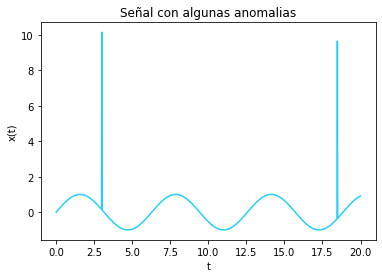

In [66]:
tArray = np.linspace(0,20,1000)
xArray = np.sin(tArray)
nAnomalies = 2
anomalyRange = 10

anomaliesIndexes = random.choices(list(range(0,len(tArray))), k = nAnomalies)
for i in range(0,len(anomaliesIndexes)):
    index = anomaliesIndexes[i]
    xArray[index] = xArray[index] +anomalyRange

plt.figure()
plt.plot(tArray, xArray, color = "#23cffa")
plt.title("Señal con algunas anomalias")
plt.xlabel("t")
plt.ylabel("x(t)")

In [100]:
alpha = 0.005
neuronsWidth = 50
neuronsHeight = 50
filterOrder = 5
immersionSize = 5



anomalyDetector = OperatorSOMAnomalyDetector(alpha, xArray, neuronsWidth, neuronsHeight, immersionSize)

In [101]:
eta = 0.01
radius = 5
epochs = 1000

errors = anomalyDetector.trainSOM(eta, radius, epochs)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 46.42it/s]


Computing quantization errors


100%|███████████████████████████████████████████████████████████████████████████████| 995/995 [00:07<00:00, 139.40it/s]

9.746908243393054e-07
0.014795313602314479


Text(0, 0.5, 'Error de cuatización')

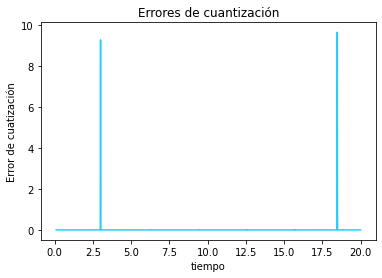

In [102]:
plt.figure()
#plt.plot(tArray, xArray)
plt.plot(tArray[immersionSize:], errors, color = "#23cffa")
plt.title("Errores de cuantización")
plt.xlabel("tiempo")
plt.ylabel("Error de cuatización")

100%|███████████████████████████████████████████████████████████████████████████████| 995/995 [00:07<00:00, 140.10it/s]


Obtained labels


Text(0, 0.5, 'x(t)')

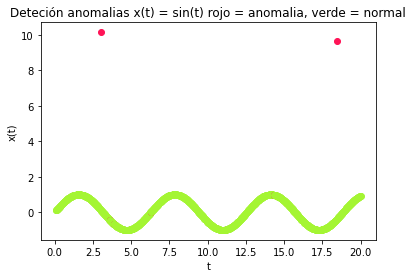

In [104]:
labels = anomalyDetector.labelAnomalies()
print("Obtained labels")
colorNormal = "#a4f533"
colorAnomaly = "#ff1457"
plt.figure()
for i in range(0,len(xArray) - immersionSize):
    label =labels[i]
    if(label == 0):
        plt.plot(tArray[i+immersionSize], xArray[i + immersionSize], marker = "o", linestyle = "none", color = colorNormal)
    elif(label == 1):
        plt.plot(tArray[i+immersionSize], xArray[i + immersionSize], marker = "o", linestyle = "none", color = colorAnomaly)
        
plt.title("Deteción anomalias x(t) = sin(t) rojo = anomalia, verde = normal")
plt.xlabel("t")
plt.ylabel("x(t)")

Text(0.5, 1.0, 'Matrix U')

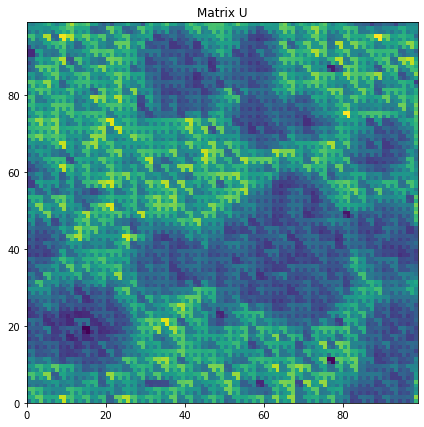

In [103]:
#Tracemos la Matriz - U en este ejemplo. 
uMatrix = anomalyDetector.operatorSOM.getUMatrix()
#threshold = 50
#for i in range(0,np.size(uMatrix,0)):
#    for j in range(0,np.size(uMatrix, 1)):
#        if(uMatrix[i,j] > threshold):
#            uMatrix[i,j] = 50




plt.figure(figsize = (7,7))
plt.pcolormesh(uMatrix*255/np.max(uMatrix))
plt.title("Matrix U")


In [110]:
def readFileModified(filePath):
    data = []
    with open(filePath, "r") as csvFile:
        csvReader = csv.reader(csvFile, delimiter = ",")
        lineCounter = 0
        for row in csvReader:
            if(lineCounter == 0):
                lineCounter += 1
            else:
                vector = []
                for i in range(0,len(row)):
                    #Si el dato no esta vacio
                    if(row[i] != ''):
                        vector.append(row[i])
                    else:
                        #Si el dato está vacio voy a almacenar un -1
                        #No es muy elegante la solución pero creo que funcionará
                        vector.append(-1)
                data.append(vector)
    return np.array(data)

In [111]:
dat = readFileModified("health_data.csv")

Text(0.5, 1.0, 'HR Máxima')

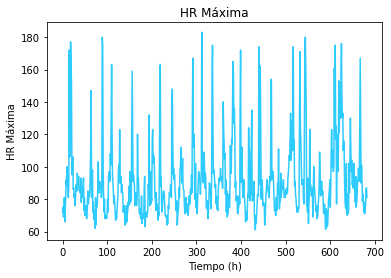

In [120]:
maxHeartRate = []
avgHeartRate = []
for i in range(0,len(dat[:,2])):
    maxHeartRate.append(float(dat[i,2]))
    avgHeartRate.append(float(dat[i,3]))

plt.figure()
plt.plot(list(range(0,len(maxHeartRate))), maxHeartRate, color = "#2ecbff")
plt.xlabel("Tiempo (h)")
plt.ylabel("HR Máxima")
plt.title("HR Máxima")

In [163]:
alpha = 0.005
neuronsWidth = 50
neuronsHeight = 50
filterOrder = 5
immersionSize = 5



anomalyDetector = OperatorSOMAnomalyDetector(alpha, maxHeartRate, neuronsWidth, neuronsHeight, immersionSize)

In [164]:
eta = 0.00001
radius = 5
epochs = 1000

errors = anomalyDetector.trainSOM(eta, radius, epochs)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:22<00:00, 44.74it/s]


Computing quantization errors


100%|███████████████████████████████████████████████████████████████████████████████| 678/678 [00:04<00:00, 141.53it/s]

0.0
0.28586572591607207


Text(0, 0.5, 'Error de cuatización')

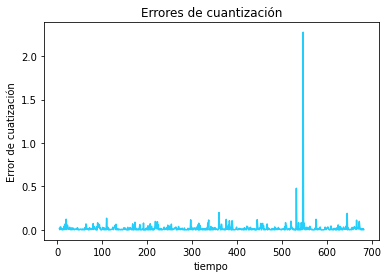

In [165]:
plt.figure()
#plt.plot(tArray, xArray)
plt.plot(list(range(0,len(maxHeartRate)))[immersionSize :], errors, color = "#23cffa")
plt.title("Errores de cuantización")
plt.xlabel("tiempo")
plt.ylabel("Error de cuatización")

100%|███████████████████████████████████████████████████████████████████████████████| 678/678 [00:05<00:00, 133.65it/s]


Obtained labels


Text(0, 0.5, 'maxHeartRate')

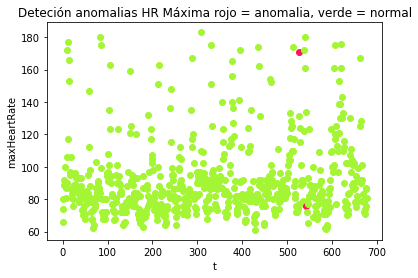

In [166]:
labels = anomalyDetector.labelAnomalies()
print("Obtained labels")
colorNormal = "#a4f533"
colorAnomaly = "#ff1457"
plt.figure()
for i in range(0,len(maxHeartRate) - immersionSize):
    label =labels[i]
    if(label == 0):
        plt.plot(i, maxHeartRate[i + immersionSize], marker = "o", linestyle = "none", color = colorNormal)
    elif(label == 1):
        plt.plot(i, maxHeartRate[i + immersionSize], marker = "o", linestyle = "none", color = colorAnomaly)
        
plt.title("Deteción anomalias HR Máxima rojo = anomalia, verde = normal")
plt.xlabel("t")
plt.ylabel("maxHeartRate")

Text(0.5, 1.0, 'Matrix U')

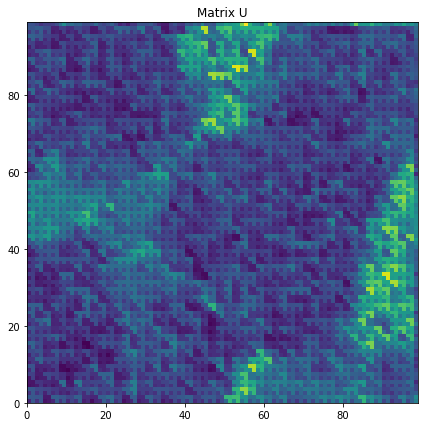

In [167]:
#Tracemos la Matriz - U en este ejemplo. 
uMatrix = anomalyDetector.operatorSOM.getUMatrix()
#threshold = 50
#for i in range(0,np.size(uMatrix,0)):
#    for j in range(0,np.size(uMatrix, 1)):
#        if(uMatrix[i,j] > threshold):
#            uMatrix[i,j] = 50




plt.figure(figsize = (7,7))
plt.pcolormesh(uMatrix*255/np.max(uMatrix))
plt.title("Matrix U")